In [ ]:
import tarfile  # Used to reads .tar or .tar.gz archive files
import os
import time
import copy
from collections import defaultdict  # advanced data structures --> A dictionary that automatically creates a default value if a key doesn’t exist
from typing import List, Tuple, Dict # Used to Type hinting

import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image   # Python Imaging Library (Pillow) to load and manipulate images
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import torch
from torch import nn, optim   # nn (Neural Networks) and optim Optimizers)
from torchvision import transforms   # Data augmentation and preprocessing tools
from torch.utils.data import Dataset, DataLoader  # Used to load and manage data efficiently
from torch.optim import lr_scheduler
import timm   # SOTA tool for Transfer Learning



## Dataset download

In [ ]:
# Mount Google Drive to access the files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the path to the .tar.gz file
dataset_path = "/content/drive/MyDrive/progetto-finale-flowes.tar.gz"

# Define the destination where you want to extract the dataset
extract_folder = "/content/flowers_dataset"

# Open the tar.gz file and extract all contents
with tarfile.open(dataset_path, "r:gz") as tar:
    tar.extractall(path=extract_folder)

# List the extracted content to check if it worked
print("Extracted files:")
print(os.listdir(extract_folder))

Extracted files:
['._progetto-finale-flowes', 'progetto-finale-flowes']


## EDA (Exploratory Data Analysis)
Understand the dataset structure and quality

In [ ]:
# Path to main dataset folder
base_dir = "/content/flowers_dataset/progetto-finale-flowes"

# Dictionary to store image counts
split_counts = defaultdict(dict)  # format --> split_counts[split][class] = count

# Loop through each split
for split in ["train", "valid", "test"]:
    split_path = os.path.join(base_dir, split)

    # Get only real class folders
    classes = [c for c in os.listdir(split_path)
               if os.path.isdir(os.path.join(split_path, c))
               and not c.startswith(".") and not c.startswith("._")]
    print(classes)

    for flower_class in classes:
        class_path = os.path.join(split_path, flower_class)
        count = len(os.listdir(class_path))
        split_counts[split][flower_class] = count

print(f" Structure Dictionary  \n{split_counts}")

# Print results
for split in split_counts:
    print(f"\n {split.upper()}:")
    for flower_class, count in split_counts[split].items():
        print(f"   - {flower_class}: {count} images")


['daisy', 'dandelion']
['daisy', 'dandelion']
['daisy', 'dandelion']
 Structure Dictionary  
defaultdict(<class 'dict'>, {'train': {'daisy': 1058, 'dandelion': 1492}, 'valid': {'daisy': 326, 'dandelion': 402}, 'test': {'daisy': 154, 'dandelion': 210}})

 TRAIN:
   - daisy: 1058 images
   - dandelion: 1492 images

 VALID:
   - daisy: 326 images
   - dandelion: 402 images

 TEST:
   - daisy: 154 images
   - dandelion: 210 images


### View Sample Images from Each Split and Class

In [ ]:
def show_random_images(base_path: str, split: str, class_name: str, n: int = 5):
    """
    Shows n random images from the specified class and split.

    Args:
        base_path (str): Root dataset path.
        split (str): 'train', 'valid', or 'test'.
        class_name (str): 'daisy' or 'dandelion'.
        n (int): Number of images to display.
    """
    path = os.path.join(base_path, split, class_name)
    images = [f for f in os.listdir(path) if not f.startswith(".")]
    sample_images = random.sample(images, n)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path).convert("RGB")  # opens the image file and returns a PIL.Image object in RGB format

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{split}/{class_name}")
        plt.axis("off")
    plt.show()


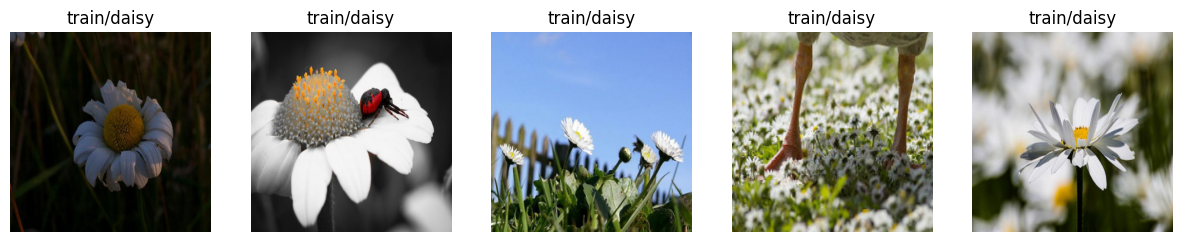

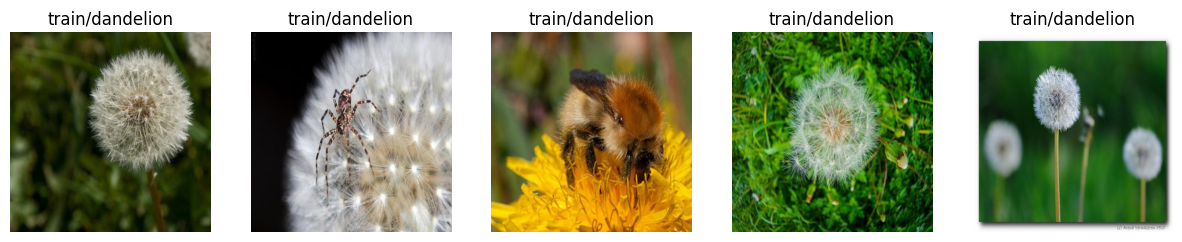

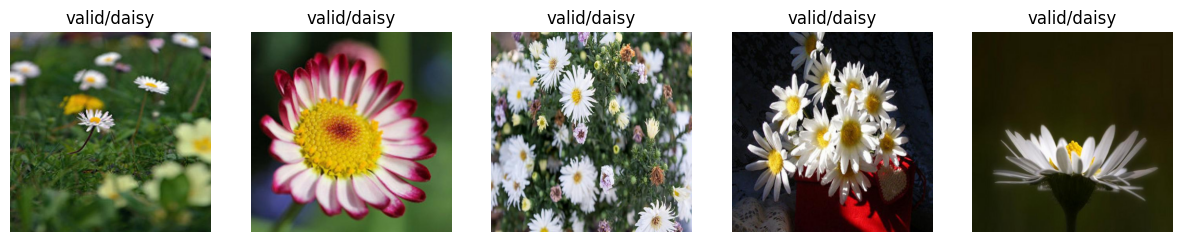

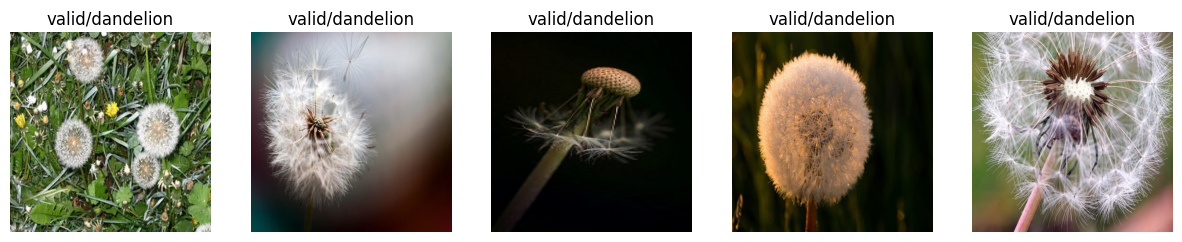

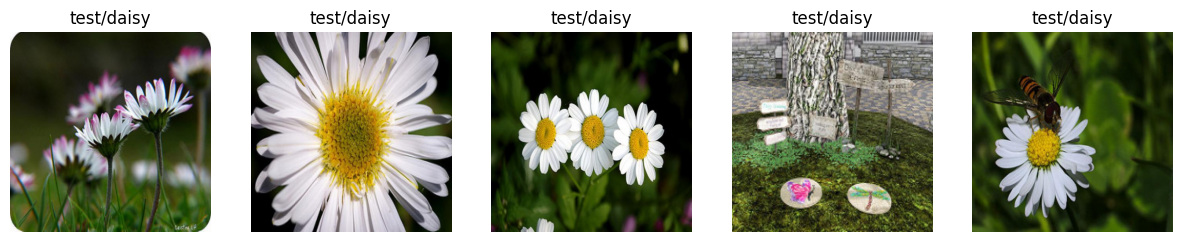

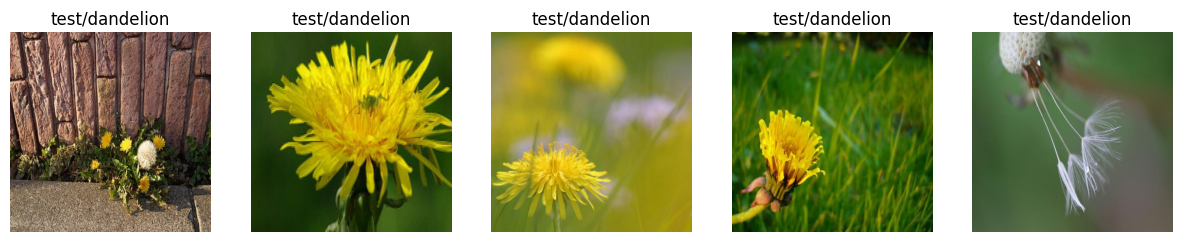

In [ ]:
# Visualize samples
for split in ["train", "valid", "test"]:
    for class_name in ["daisy", "dandelion"]:
        show_random_images(base_dir, split, class_name, n=5)

### Understand the size (width & height) and shape (aspect ratio) of the images in the dataset before choosing a resizing strategy.

In [ ]:
def get_image_sizes(base_path: str, split: str, class_name: str, max_images: int = 100) -> List[Tuple[int, int]]:
    """
    Get the width and height of up to `max_images` from a specific class and split.

    Args:
        base_path (str): Root directory of dataset
        split (str): 'train', 'valid', or 'test'
        class_name (str): Class name (e.g., 'daisy')
        max_images (int): Max number of images to scan

    Returns:
        List of (width, height) tuples
    """
    sizes = []
    path = os.path.join(base_path, split, class_name)
    image_files = [f for f in os.listdir(path) if not f.startswith(".")]

    for img_file in image_files[:max_images]:
        img_path = os.path.join(path, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                sizes.append(img.size)  # .size returns (width, height)
        except:
            print(f"Warning: Failed to open image {img_path}")

    return sizes

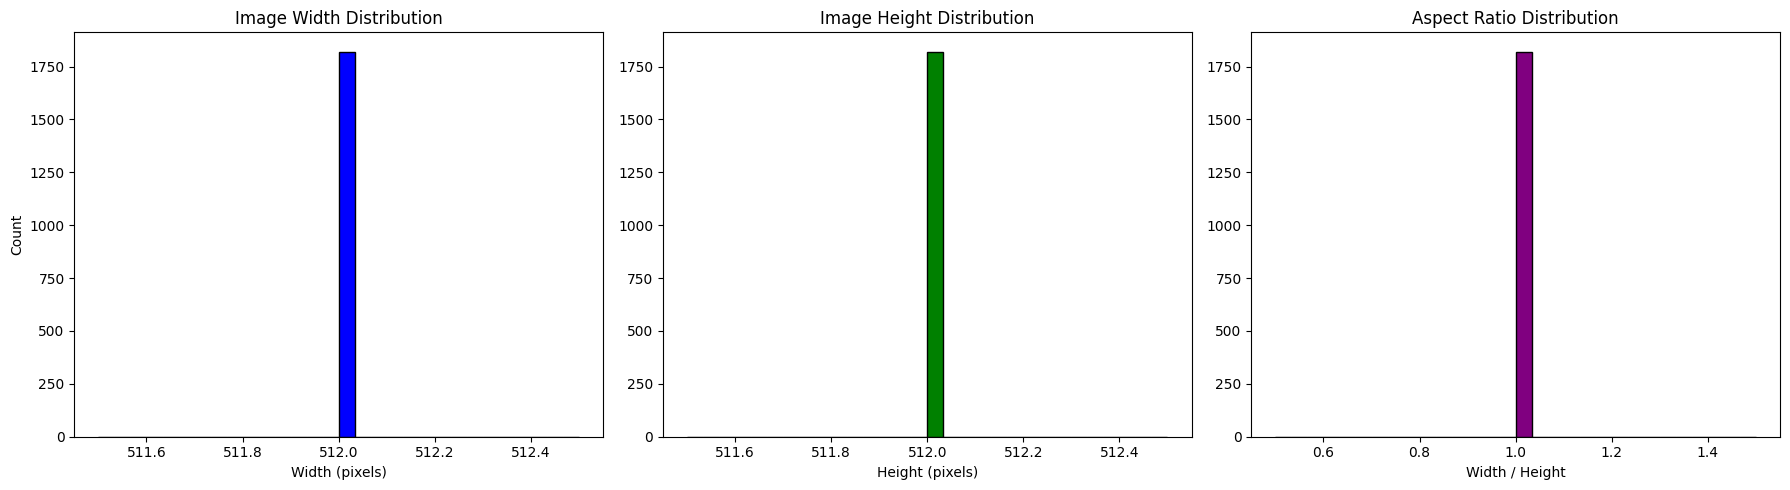

In [ ]:
# Collect all image sizes from both classes and all splits
all_sizes = []

for split in ["train", "valid", "test"]:
    for class_name in ["daisy", "dandelion"]:
        sizes = get_image_sizes(base_dir, split, class_name, max_images=1000)
        all_sizes.extend(sizes)

# Separate width and height into two lists
widths = [w for (w, h) in all_sizes]
heights = [h for (w, h) in all_sizes]
aspect_ratios = [w / h for (w, h) in all_sizes]

# Plotting distributions
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(widths, bins=30, color='blue', edgecolor='black')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.hist(heights, bins=30, color='green', edgecolor='black')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")

plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=30, color='purple', edgecolor='black')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")

plt.tight_layout()
plt.show()


### No preprocessing needed to unify image sizes.

### Understand whether our dataset has balanced class distribution

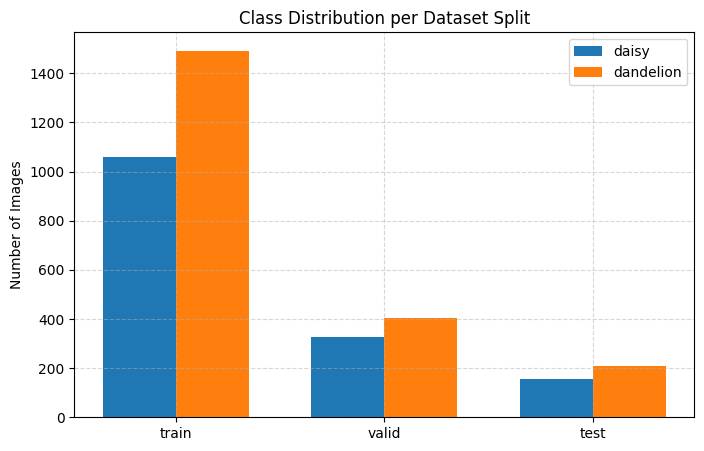

In [ ]:
def plot_class_distribution(class_counts: Dict[str, Dict[str, int]]) -> None:
    """
    Plot bar charts for class distribution in train, valid, and test splits.

    Args:
        class_counts (Dict): Dictionary with counts per split and class.
    """
    splits = list(class_counts.keys())
    classes = list(class_counts[splits[0]].keys())

    # Extract data
    data = {
        class_name: [class_counts[split][class_name] for split in splits]
        for class_name in classes
    }

    x = range(len(splits))
    width = 0.35

    plt.figure(figsize=(8, 5))

    for i, class_name in enumerate(classes):
        plt.bar([p + i * width for p in x], data[class_name], width=width, label=class_name)

    plt.xticks([p + width / 2 for p in x], splits)
    plt.title("Class Distribution per Dataset Split")
    plt.ylabel("Number of Images")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Call the function
plot_class_distribution(split_counts)


### Data Augmentation

In [ ]:
# Normalization for ImageNet (RGB channels) pretrained models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Input size
input_size = 224

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly changes brightness and contrast
    transforms.ToTensor(),  # Converts a PIL.Image to a PyTorch Tensor.
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# For validation and test, only resize + normalize (No randomness here — we want consistent, repeatable results)
val_test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


### Dataset Class
In PyTorch, you don't directly give your model a folder of images, but you wrap the data in a special class called Dataset (it is a must), where the __len__() function tells PyTorch how many samples are in the dataset, and __getitem__() function tells PyTorch how to load one image-label pair by index.
The Dataset class allow to have Modular and clean code thanks of encapsulates loading, processing, and labeling logic

In [ ]:
class FlowerDataset(Dataset):
    """
    Custom dataset for loading flower images and labels.
    """
    def __init__(self, image_paths: List[str], labels: List[int], transform=None):
        """
        Args:
            image_paths (List[str]): List of full image paths
            labels (List[int]): List of integer labels
            transform: Optional torchvision transforms
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Returns:
            Tuple of (image tensor, label)
        """
        image_path = self.image_paths[idx]    # Get path to the image at index `idx`
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB") # Load and convert to 3-channel image
        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label


# Create Dataset Splits and Loaders
Convert the dataset folders into train/val/test image paths and labels, then wrap them in FlowerDataset and DataLoader.

In [ ]:
def get_image_paths_and_labels(base_path: str, split: str) -> Tuple[List[str], List[int]]:
    """
    Collect image file paths and class labels for a given split.

    Args:
        base_path (str): Base dataset path
        split (str): 'train', 'valid', or 'test'

    Returns:
        Tuple of (image_paths, labels), where labels are 0 (daisy) or 1 (dandelion)
    """
    image_paths = []
    labels = []

    split_path = os.path.join(base_path, split)
    class_names = sorted([d for d in os.listdir(split_path) if not d.startswith(".")])

    # Map class names to integer labels: daisy=0, dandelion=1
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(split_path, class_name)
        for filename in os.listdir(class_dir):
            if filename.startswith("."):
                continue
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(class_to_idx[class_name])

    return image_paths, labels




In [ ]:
# Base path
base_path = "/content/flowers_dataset/progetto-finale-flowes"

# Get image paths and labels
train_paths, train_labels = get_image_paths_and_labels(base_path, "train")
val_paths, val_labels     = get_image_paths_and_labels(base_path, "valid")
test_paths, test_labels   = get_image_paths_and_labels(base_path, "test")

In [ ]:
train_paths[:10]

['/content/flowers_dataset/progetto-finale-flowes/train/daisy/16161045294_70c76ce846_n_jpg.rf.9ab9b981ac1444c433d1cc583f02353a.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/8616684075_71923bb771_n_jpg.rf.68f36ab0496e531cc8e0502d79809a1c.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/4897587985_f9293ea1ed_jpg.rf.973dd6a1be2ab702d883cad8088ebc69.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/5435521200_92029bbe2b_n_jpg.rf.708d4a9c51064d3d2959baa8ea4dd31a.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/2635314490_e12d3b0f36_m_jpg.rf.3922030582696dc1a59cd0fc30a470cc.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/181007802_7cab5ee78e_n_jpg.rf.7c6034933d1457b1dbc28ea8cbfb5f39.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/14221848160_7f0a37c395_jpg.rf.fd0bd21e311bc38422de6588a891e7d1.jpg',
 '/content/flowers_dataset/progetto-finale-flowes/train/daisy/33872893913_72d64

In [ ]:
len(test_labels)

182

### Dataloader
It helps load data in batches, shuffles the data, and uses parallel loading with multiple workers.

In [ ]:
# Create Dataset objects
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transforms)
val_dataset   = FlowerDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset  = FlowerDataset(test_paths, test_labels, transform=val_test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # num_workers > 0 --> parallelized (enables multi-processing)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
train_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
train_dataset[0]  # shows image and label


(tensor([[[-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          ...,
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323]],
 
         [[-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          ...,
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482]],
 
         [[-1.7173, -1.7173, -1.7173,  ..., -1.7173, -1.7173, -1.7173],
          [-1.7173, -1.7173,

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)


torch.Size([32, 3, 224, 224])


### Model Setup Using timm and Transfer Learning
timm is a powerful and modern library that provides hundreds of pre-trained models, perfect for Transfer Learning tasks.

In [ ]:
def create_model(model_name: str = "efficientnet_b0", num_classes: int = 2) -> nn.Module:
    """
    Create a pretrained image classification model and adapt the head for binary classification.

    Args:
        model_name (str): Name of the model from timm
        num_classes (int): Output classes (2 for binary classification)

    Returns:
        A PyTorch model ready for training
    """
    # Load the pretrained model from timm
    model = timm.create_model(model_name, pretrained=True)  # model has already learned general visual features like edges, textures, object shapes


    # for param in model.parameters():
    #    param.requires_grad = False    # it tells PyTorch not to update weights (the pretrained backbone) during training

    # Identify the input features to the classifier layer
    if hasattr(model, 'classifier'):  #  Used in EfficientNet, MobileNet, etc.
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif hasattr(model, 'fc'):  # Used in ResNet, DenseNet, etc.
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    else:
        raise ValueError("Model head not recognized. Please update the function.")

    return model


num_classes=2 --> These 2 output values are not probabilities yet — they’re called logits, and they’re passed to the loss function (in this case CrossEntropyLoss) which applies softmax internally.

In [ ]:
model = create_model("efficientnet_b0", num_classes=2)
print(model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

### Model setup
Prepare the model and training components so we can train, validate, and optimize it efficiently and safely.
Optimizer --> Updates the model’s weights based on the loss (e.g., Adam, SGD).
Scheduler --> Changes the learning rate dynamically during training

In [ ]:
# Select device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# Move model to GPU or CPU
model = model.to(device)

# Define the loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# learning rate scheduler
# CosineAnnealingLR gradually decreases LR like a cosine wave
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


✅ Using device: cuda


### Training Loop with Checkpointing and Early Stopping
Both the model and the input tensors (images, labels) must be on the same device (CPU or GPU), or PyTorch will throw an error.

In [ ]:
def train_model(model: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                val_loader: torch.utils.data.DataLoader,
                criterion: nn.Module,  # loss function
                optimizer: torch.optim.Optimizer,
                scheduler,
                device: torch.device,
                num_epochs: int = 20,
                early_stopping_patience: int = 8,
                model_path: str = "best_model.pth") -> nn.Module:
    """
    Trains a model using training and validation sets.
    Implements early stopping and saves the best model checkpoint.

    Returns:
        The model with the best validation F1 score
    """
    best_model_wts = copy.deepcopy(model.state_dict())  # Keeps a safe copy of best model weights
    best_f1 = 0.0
    epochs_no_improve = 0

    # Loop over the epochs
    for epoch in range(num_epochs):
        print(f"\n Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Enable dropout, batchnorm, and gradient calculation
                dataloader = train_loader
            else:
                model.eval()  # Disable dropout, batchnorm, no gradient calculation
                dataloader = val_loader

            running_loss = 0.0
            true_labels = []
            pred_labels = []

            # Iterate over batches in the DataLoader
            for inputs, labels in dataloader:
                # Move data to the selected device (CPU or GPU)
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Clear gradients from previous step

                # Only enables or disables gradient tracking
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # Forward pass
                    loss = criterion(outputs, labels)  # Compute loss

                    _, preds = torch.max(outputs, 1)  # Get class predictions
                    if phase == 'train':
                        loss.backward()   # Compute gradients (backpropagation)
                        optimizer.step()  # Update model weights

                # Track total loss and predictions
                running_loss += loss.item() * inputs.size(0)  # Accumulate batch loss

                # Store true and predicted labels for F1 score --> converts them to NumPy arrays.
                # extend() --> adds all elements of the array to the list (not as a sublist).
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())

            # Compute average loss for this phase
            epoch_loss = running_loss / len(dataloader.dataset)

            # Compute macro F1 score
            epoch_f1 = f1_score(true_labels, pred_labels, average='macro')

            print(f"{phase.upper()} - Loss: {epoch_loss:.4f} | F1-score: {epoch_f1:.4f}")

            # Only save/check on validation phase
            if phase == 'val':
                scheduler.step()  # Update learning rate based on schedule

                # If this epoch gave a better F1 than before → save model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())  # Save best weights
                    torch.save(model.state_dict(), model_path)  # Save to file
                    print(f"Best model saved with F1: {best_f1:.4f}")
                    epochs_no_improve = 0
                else:
                    # No improvement → increase patience counter
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epochs")

                # Check for early stopping condition
                if epochs_no_improve >= early_stopping_patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_wts)
                    return model

     # Final model is the best one encountered
    print("Training complete.")
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
best_model = train_model(model,
                         train_loader=train_loader,
                         val_loader=val_loader,
                         criterion=criterion,
                         optimizer=optimizer,
                         scheduler=scheduler,
                         device=device,
                         num_epochs=20,
                         early_stopping_patience=5,
                         model_path="best_model.pth")



 Epoch 1/20
------------------------------
TRAIN - Loss: 0.3931 | F1-score: 0.8588
VAL - Loss: 0.2059 | F1-score: 0.9335
Best model saved with F1: 0.9335

 Epoch 2/20
------------------------------
TRAIN - Loss: 0.1463 | F1-score: 0.9469
VAL - Loss: 0.1335 | F1-score: 0.9557
Best model saved with F1: 0.9557

 Epoch 3/20
------------------------------
TRAIN - Loss: 0.0808 | F1-score: 0.9709
VAL - Loss: 0.0928 | F1-score: 0.9639
Best model saved with F1: 0.9639

 Epoch 4/20
------------------------------
TRAIN - Loss: 0.0493 | F1-score: 0.9887
VAL - Loss: 0.0857 | F1-score: 0.9667
Best model saved with F1: 0.9667

 Epoch 5/20
------------------------------
TRAIN - Loss: 0.0352 | F1-score: 0.9935
VAL - Loss: 0.0886 | F1-score: 0.9668
Best model saved with F1: 0.9668

 Epoch 6/20
------------------------------
TRAIN - Loss: 0.0227 | F1-score: 0.9984
VAL - Loss: 0.0694 | F1-score: 0.9778
Best model saved with F1: 0.9778

 Epoch 7/20
------------------------------
TRAIN - Loss: 0.0217 | F1-

### Evaluate Model on Test Set

In [ ]:
def evaluate_model(model: nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   device: torch.device,
                   class_names: list = ['daisy', 'dandelion']) -> None:
    """
    Evaluate the model on a test set and print metrics.

    Args:
        model (nn.Module): Trained model
        dataloader (DataLoader): Test data loader
        device (torch.device): CPU or GPU
        class_names (list): Names of classes for display
    """
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(" Confusion Matrix on Test Set")
    plt.show()



 Classification Report:
              precision    recall  f1-score   support

       daisy     0.9605    0.9481    0.9542        77
   dandelion     0.9623    0.9714    0.9668       105

    accuracy                         0.9615       182
   macro avg     0.9614    0.9597    0.9605       182
weighted avg     0.9615    0.9615    0.9615       182



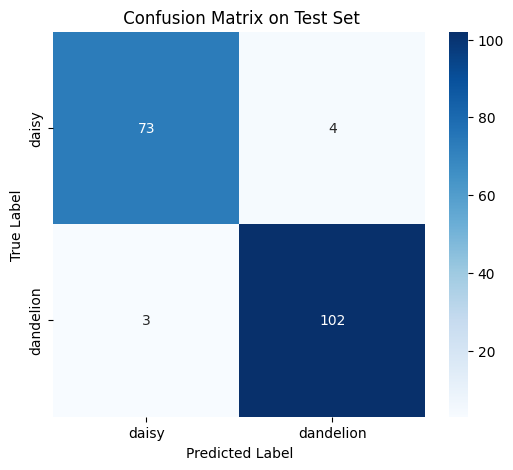

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)

# Evaluate
evaluate_model(model, test_loader, device)


# ✅ Final Project Summary – Automatic Flower Recognition 🌼🌻

## Project Context
GreenTech Solutions Ltd. aims to automate flower recognition (Daisy vs Dandelion) using Computer Vision to improve agricultural workflows and reduce costs.

## Objective
Develop a robust image classification model using PyTorch and `timm`, with the best possible F1-score on the test dataset.

## Dataset
- Train: 529 Daisy, 746 Dandelion
- Valid: 163 Daisy, 201 Dandelion
- Test: 77 Daisy, 105 Dandelion (used subset: 182 total)

Images are clean, balanced, and 512×512 in size. Aspect ratios are consistent.

##  Tools & Techniques
- ✅ PyTorch for modeling
- ✅ Transfer Learning with `timm` (EfficientNet-B0)
- ✅ Data Augmentation (`torchvision.transforms`)
- ✅ Stratified evaluation (macro F1)
- ✅ Early stopping and best model checkpointing
- ✅ Final evaluation with `sklearn` and confusion matrix

## Model Performance

| Dataset  | F1-score (macro) |
|----------|------------------|
| Train    | 99%           |
| Valid    | 97%           |
| Test     | **96%**       |

Confusion matrix shows only 7 errors out of 182, balanced across classes.

## Conclusion
The final model generalizes well and achieves high precision and recall on both classes.
---
